Notebook objective: Train & test mixed effects linear model. Goal is to compare performance, SHAP values & fixed effects with GPB.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupKFold
import gpboost as gpb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

## Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./OutputData/training_data.csv")

In [5]:
# Split features, groupings and target
X = df.drop(["life_expectancy", "country", "year"], axis = 1)
G = df[["country", "year"]]
y = df.life_expectancy

In [6]:
# Create cv splitter
cv = GroupKFold(n_splits = 4)

In [7]:
scaler = MinMaxScaler()

## Testing & diagnostics

In [8]:
# Initialize lists to store validation results
val_list = []
preds_list = []
resids_list = []
scores_mse = []
scores_rmse = []
scores_mape = []

In [9]:
# Perform crossvalidation
for i, (train_index, val_index) in enumerate(cv.split(X = X, groups = G.country)):

    # Split train - val
    X_train, G_train, y_train = X.iloc[train_index, ], G.iloc[train_index, ], y[train_index]
    X_val, G_val, y_val = X.iloc[val_index, ], G.iloc[val_index, ], y[val_index]

    # Preprocess features
    X_train = scaler.fit_transform(X_train, y_train)
    X_val = scaler.transform(X_val)

    # Add intercept
    X_train = np.hstack(
        (X_train, np.ones((len(X_train), 1)))
    )
    X_val = np.hstack(
        (X_val, np.ones((len(X_val), 1)))
    )

    # Train mixed effects model
    train = gpb.Dataset(X_train, y_train)
    val = gpb.Dataset(X_val, y_val)

    gp_model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian",
        seed = random_state
    )

    gp_model.fit(X = X_train, y = y_train, params = {"std_dev": True})

    # Save actual values
    val_list.append(y_val)

    # Make predictions on test data
    preds = gp_model.predict(X_pred = X_val, group_data_pred = G_val, predict_var = True)["mu"]
    preds_list.append(preds)

    # Calculate prediction residuals
    resids = y_val - preds
    resids_list.append(resids)

    # Calculate scores
    mse = mean_squared_error(y_val, preds)
    scores_mse.append(mse)

    rmse = mean_squared_error(y_val, preds, squared = False)
    scores_rmse.append(rmse)

    mape = mean_absolute_percentage_error(y_val, preds)
    scores_mape.append(mape)

In [10]:
# Calculate MSE, RMSE, MAPE
print("MSE:")
print(round(np.mean(scores_mse), 4))

print("RMSE:")
print(round(np.mean(scores_rmse), 4))

print("MAPE:")
print(round(np.mean(scores_mape), 4))

MSE:
34.7144
RMSE:
5.8819
MAPE:
0.0726


Considerably better testing performance compared to fixed effects LM.

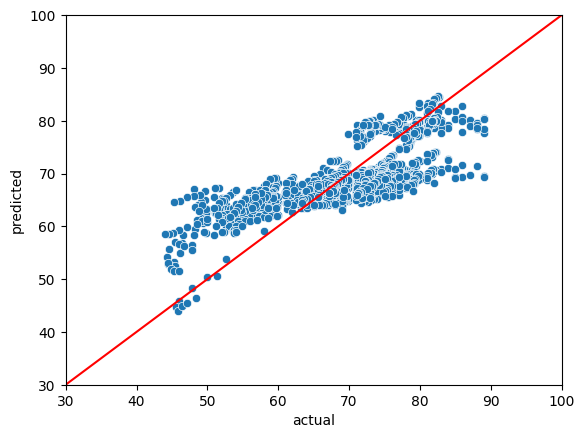

In [11]:
# Plot predicted vs. actual
_ = sns.scatterplot(
    x = np.concatenate(val_list).ravel(),  
    y = np.concatenate(preds_list).ravel()
)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

The model is able to react to some extreme cases, and predict from a range of 45 to 85, unlike LM. This suggests the fixed effect parameters generalize better out-of-sample due to the presence of random intercepts.

Most observations are still either underpredicted or overpredicted, and most predictions are still between 60-75.

A few extreme observations with very low life expectancy are predicted very well out-of-sample, this suggests some predictors (possibly HIV) strongly explain their circumstances.

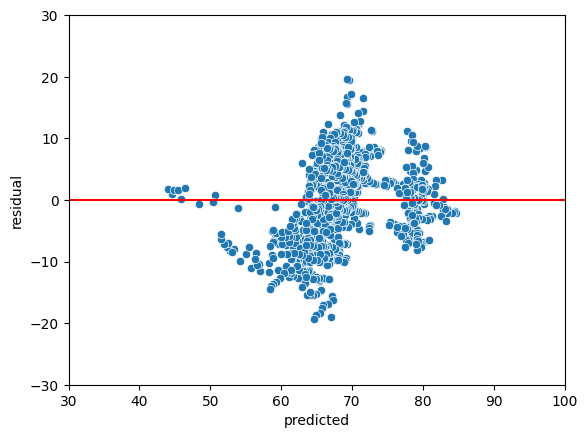

In [12]:
# Predicted vs residual
_ = sns.scatterplot(
    x = np.concatenate(preds_list).ravel(), 
    y = np.concatenate(resids_list).ravel()
)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(-30, 30)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

## Inference

In [13]:
# Prepare data for final model
X_scaled = scaler.fit_transform(X, y)
X_scaled = np.hstack(
        (X_scaled, np.ones((len(X_scaled), 1)))
)
cols = X.columns.values.tolist()
cols.append("intercept")
X_scaled = pd.DataFrame(X_scaled, columns = cols)
train = gpb.Dataset(X_scaled, y)

In [14]:
# Train final model
gp_model = gpb.GPModel(
        group_data = G,
        likelihood = "gaussian",
        seed = random_state
    )

gp_model.fit(X = X_scaled, y = y, params = {"std_dev": True})

In [15]:
# Get fitted values & residuals
fitted = gp_model.predict(X_pred = X_scaled, group_data_pred = G, predict_var = True)["mu"]
fitted_resids = y - fitted

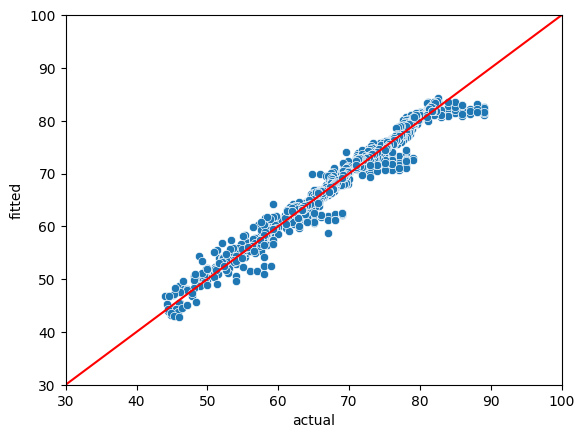

In [16]:
# Plot fitted vs. actual
_ = sns.scatterplot(
    x = y,  
    y = fitted
)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("fitted")

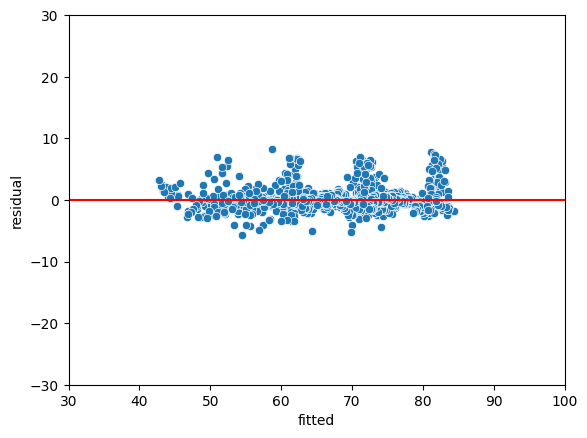

In [17]:
# Plot fitted vs. residual
_ = sns.scatterplot(
    x = fitted, 
    y = fitted_resids
)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(-30, 30)
_ = plt.xlabel("fitted")
_ = plt.ylabel("residual")

There are several "pillars" of underpredicted countries in the fitted residuals plot. These could be countries that have higher life expectancy than the predictors suggest, due to factors outside this dataset.

In [18]:
gp_model.summary()

Model summary:
     Log-lik         AIC         BIC
-3541.700000 7123.400000 7231.560000
Nb. observations: 1649
Nb. groups: 133 (country), 16 (year)
-----------------------------------------------------
Covariance parameters (random effects):
              Param.  Std. dev.
Error_term  2.803500   0.102300
country    33.895700   4.193400
year        0.559200   0.220800
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                                    Param.  Std. dev.    z value  P(>|z|)
alcohol                          -1.190800   0.562400  -2.117500 0.034200
percentage_expenditure           -1.371500   2.321500  -0.590800 0.554700
hepatitis_b                       0.395000   0.236400   1.671000 0.094700
measles                          -0.632800   0.845300  -0.748700 0.454000
bmi                               0.086500   0.257200   0.336500 0.736500
polio                            -0.026100   0.251300  -0.104000 0.917200
total_exp

Considerable differences from LM's estimated fixed effects. Most notably:
- The fixed intercept is now 70, very close to the target mean overall.
- HIV's effect is roughly three times compared to the one in LM.
- Developing's effect is much larger, and is now negative, as expected.

Both the better out-of-sample predictive parformance, and the more intuitive coefficient directions suggest these estimates are likely more realistic compared to LM.

In [19]:
# Get model parameters for SHAP
coefs = gp_model.get_coef().iloc[:-1, :-1].values.flatten()
intercept = gp_model.get_coef().iloc[:-1, -1].values

In [20]:
# Get data parameters for SHAP
X_train_no_intercept = X_scaled.drop("intercept", axis = 1)
means = X_train_no_intercept.mean().values
covs = X_train_no_intercept.cov().values

In [21]:
# Get SHAP values
explainer = shap.LinearExplainer(
    (coefs, intercept), 
    (means, covs)
)
explainer.expected_value = explainer.expected_value[0] # To fix slicing issue with some SHAP plots
shap_values = explainer(X_train_no_intercept)

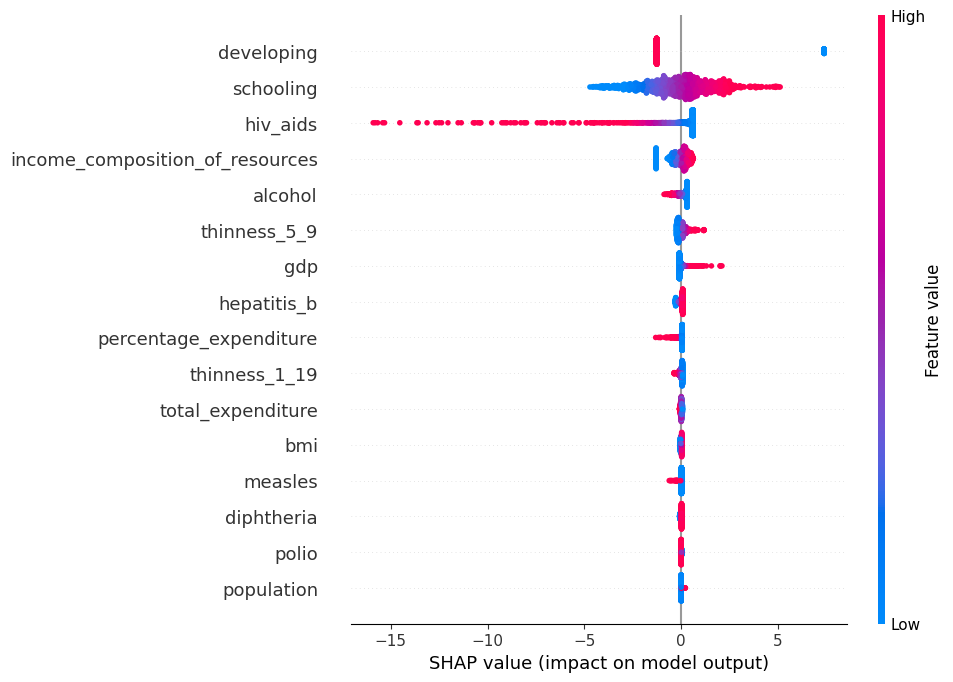

In [22]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values, max_display = 20)

Without the presence of country as a predictor, developing becomes the top predictor on average, though several others have much bigger effects for extreme observations. Most notably, HIV.

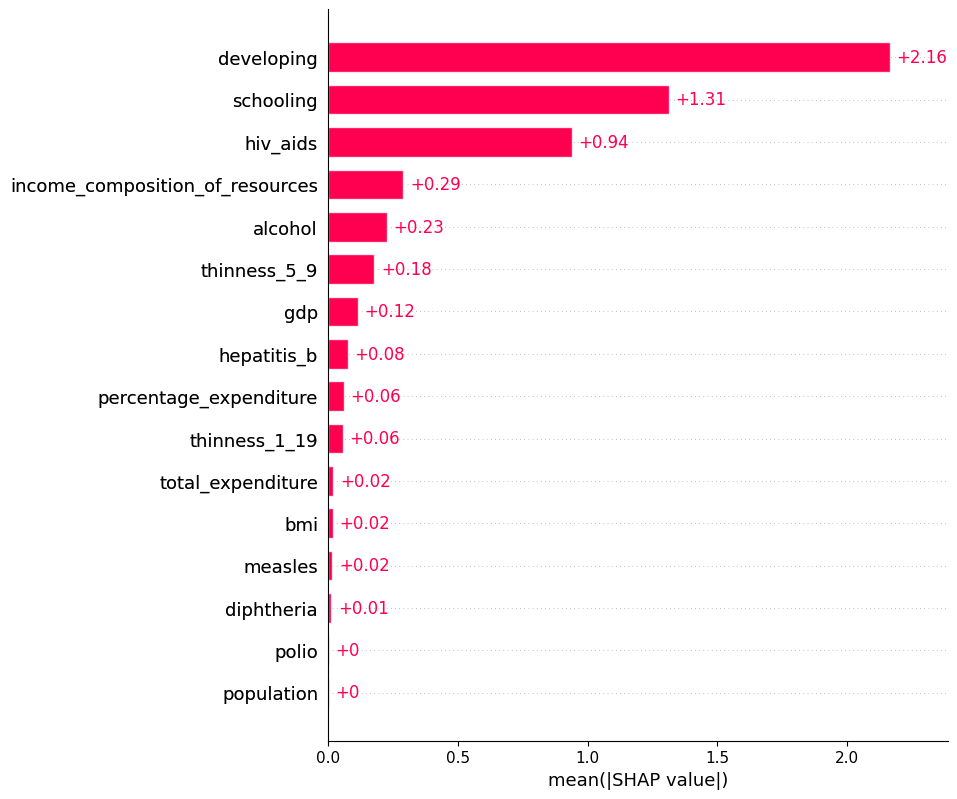

In [23]:
shap.plots.bar(shap_values, max_display = 20)